#**WHAT I DID IN THIS NOTEBOOK:**

**In previous notebooks I used MAE as a metric of measure. However I then changed to using accuracy as a measure by changing the regression problem into classification where I found how I could predict datapoints of the closing price by creating EMA, normalizing the dataset and stacking X and finding Y based on X**

**I then used this dataset to split into test, train and validate sets.** 

**I stacked the OHLCV data and used that as X and closing prices as Y hence genetrated  the classification problem.** 

**Then I predicted the accuacy.** 

**I used hyperparemeter tuning for the LSTM model and ran a GRU cell with some hyperparameter too.**


**Importing packages from keras**

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
from google.colab import drive

# This will prompt for authorization.
# drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [0]:
googlepath = "/content/drive/My Drive/"

In [0]:
#!python /content/drive/'My Drive'/utils.py install

In [26]:
from google.colab import files
src = list(files.upload().values())[0]

Saving utils.py to utils (1).py


In [0]:
open('utils.py','wb').write(src)
from utils import *

**utils.py is a python package having tickers for time series data. You can** 

**upload it using the above command. Recommend to download it using**
https://pypi.org/project/python-utils/ **and storing in drive.** 


In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=1CQDa0VJP0cEKxO9hRpyxngnJIxYaVwTV' # The shareable link

In [16]:
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

1CQDa0VJP0cEKxO9hRpyxngnJIxYaVwTV


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('AMZN.csv')  
data_original = pd.read_csv('AMZN.csv')[::-1]

In [30]:


import pandas as pd
import matplotlib.pylab as plt

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D, RepeatVector
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.layers.wrappers import Bidirectional
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.initializers import *

import seaborn as sns
sns.despine()


<Figure size 432x288 with 0 Axes>

**Imported all keras files**

# NEXT STEPS

**DATA MANIPULATION, NORMALIZATION AND EMA(Exponential moving average) CALCULATION**

**WHAT I AM TRYING TO DO:** 

**INSTEAD OF MAE I WILL TRY TO MEASURE ACCURACY OF MY LSTM NETWORK BY CONVERTING THE REGRESSION PROBLEM INTO CLASSIFICATION.** 

**I WILL TRY TO PREDICT CLOSING PRICES DATAPOINT TO DATAPOINT AND SEE HOW WELL MY NORMALIZED DATASET CAN PREDICT THE CLOSING VALUES**

In [31]:
#data_original = pd.read_csv('datastrat2.csv')[::-1]

openp = data_original.ix[:, 'Open'].tolist()  #convert all OHLCV data into list formats so appending will be easy
highp = data_original.ix[:, 'High'].tolist()
lowp = data_original.ix[:, 'Low'].tolist()
closep = data_original.ix[:, 'Close'].tolist()
volumep = data_original.ix[:, 'Volume'].tolist()


WINDOW = 30   #Keep a window of 30 days for EMA
EMB_SIZE = 5  
STEP = 1
FORECAST = 1 #One day ahead forecast as before 
X, Y = [], []
for i in range(0, len(data_original), STEP):  #create a counter for data with step size 1
    try:
        o = openp[i:i+WINDOW]  #declare a window and sample through each stock price
        h = highp[i:i+WINDOW]
        l = lowp[i:i+WINDOW]
        c = closep[i:i+WINDOW]
        v = volumep[i:i+WINDOW]

        o = (np.array(o) - np.mean(o)) / np.std(o)  # normalize the stock values by fiding differnce in array lenth and mean and dividing by standard dev
        h = (np.array(h) - np.mean(h)) / np.std(h)
        l = (np.array(l) - np.mean(l)) / np.std(l)
        c = (np.array(c) - np.mean(c)) / np.std(c)
        v = (np.array(v) - np.mean(v)) / np.std(v)

        x_i = closep[i:i+WINDOW]           #create train for close price and add forecast for output price
        y_i = closep[i+WINDOW+FORECAST]  

        last_close = x_i[-1]
        next_close = y_i

        if last_close < next_close: 
            y_i = [1, 0]
        else:
            y_i = [0, 1] 

        x_i = np.column_stack((o, h, l, c, v))   #do not consider any tickers that we conidered in former model.
                                                  #by creating close price treshold we create our own theshold indicator

    except Exception as e:
        break

    X.append(x_i)
    Y.append(y_i)

X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], EMB_SIZE))  #reshape train so that can be fed into LSTM network
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], EMB_SIZE))


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.
/usr/

**My Algorithm:**

**1. create train for close price and add forecast for output price**

**2. create train for close price and add forecast for output price**

**3. do not consider any tickers that we conidered in former model.**

**4. by creating close price treshold we create our own theshold indicator**

**USE LSTM NETWORK ARCHITECTURE**

In [0]:

def mean_pred(X_test, Y_test):
    return K.mean(Y_test)

def build_model(inputs, output_size, neurons, activ_func="relu",
                dropout=0.10, loss="mae", optimizer="adam"):
    
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(WINDOW,EMB_SIZE)))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', mean_pred])
    return model

In [33]:
nn_model = build_model(X_train, output_size=2, neurons = 32)
# model output is next price normalised to 10th previous closing price
# train model on data
# note: eth_history contains information on the training error per epoch
nn_history = nn_model.fit(X_train, Y_train,
                            epochs=20, batch_size=256, verbose=1,  validation_data=(X_test, Y_test),shuffle=True)

W0816 15:04:35.385684 139769722800000 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0816 15:04:35.392836 139769722800000 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0816 15:04:35.404253 139769722800000 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0816 15:04:35.625117 139769722800000 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0816 15:04:35.635040 

Train on 40973 samples, validate on 4553 samples
Epoch 1/20
40973/40973 [==============================] - 15s 357us/step - loss: 0.4681 - acc: 0.5405 - mean_pred: 0.2660 - val_loss: 0.4484 - val_acc: 0.5519 - val_mean_pred: 0.4311
Epoch 2/20
40973/40973 [==============================] - 12s 284us/step - loss: 0.3996 - acc: 0.6535 - mean_pred: 0.4482 - val_loss: 0.4029 - val_acc: 0.6440 - val_mean_pred: 0.4054
Epoch 3/20
40973/40973 [==============================] - 12s 283us/step - loss: 0.3740 - acc: 0.6887 - mean_pred: 0.4195 - val_loss: 0.3941 - val_acc: 0.6563 - val_mean_pred: 0.4590
Epoch 4/20
40973/40973 [==============================] - 12s 283us/step - loss: 0.3656 - acc: 0.6949 - mean_pred: 0.4187 - val_loss: 0.3886 - val_acc: 0.6613 - val_mean_pred: 0.3830
Epoch 5/20
40973/40973 [==============================] - 12s 283us/step - loss: 0.3616 - acc: 0.6977 - mean_pred: 0.4176 - val_loss: 0.3866 - val_acc: 0.6640 - val_mean_pred: 0.3846
Epoch 6/20
40973/40973 [============

**TRAINING ACCURACY AT 70.6%**

In [34]:
nn_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                4864      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
Total params: 4,930
Trainable params: 4,930
Non-trainable params: 0
_________________________________________________________________


In [35]:
acc = nn_model.evaluate(X_test, Y_test, batch_size=16)
print('Test accuracy:', acc)

4553/4553 [==============================] - 7s 1ms/step
('Test accuracy:', [0.36795512862240065, 0.6718647046427452, 0.44446592047637096])


**TESTING ACCURACY AT 67.18%**

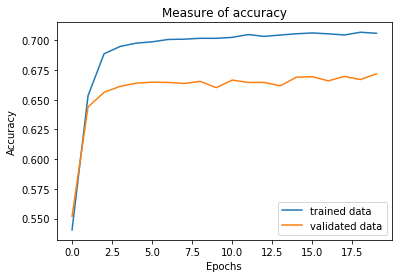

In [36]:
#Plotting training data loss and validation data loss
plt.plot(nn_history.history['acc'], label = 'trained data')
plt.plot(nn_history.history['val_acc'], label = 'validated data')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Measure of accuracy')
plt.show()

**A GOOD MODEL. NORMALIZED VALUES DIFFERENCE AT 0.025 SO NOT OVERFIT OR UNDERFIT.**

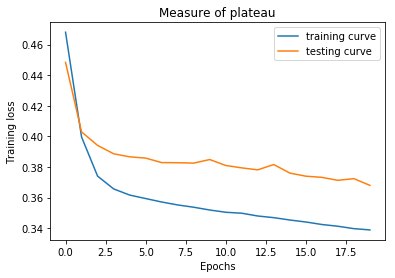

In [37]:
#plateau:
plt.plot(nn_history.history['loss'], label = 'training curve')
plt.plot(nn_history.history['val_loss'], label = 'testing curve')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.title('Measure of plateau')
plt.show()

**SUMMARY OF THIS STRATEGY: 
        great results compared to just pure stock prediction and even 
        previous simple moving average algorithm
I will now try to find the best LSTM model by tweaking epoch, cost function, actvation function and other parameters. 
Go down for other network architectures-mainly GRU and conv1D**

**HYPERPARAMETER TUNING**

**For LSTM: change activation function, cost functionand other params. We know which ones are good for seq model by previous analysis. Trying a few combinations based on past analysis:**

**1.elu and selu with rmsprop and sgd along with mse and logcosh**

**2.will try epochs 100 and 50** 

**3. will try initialzers random uniform and zeros**

In [0]:
#elu with mse and rmsprop. epoch of 100. 
#initializer random uniform.  
def mean_pred(X_test, Y_test):
    return K.mean(Y_test)

def build_model(inputs, output_size, neurons, activ_func="elu",
                dropout=0.10, loss="mse", optimizer="rmsprop"):
    
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(WINDOW,EMB_SIZE)))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size, kernel_initializer='random_uniform'))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', mean_pred])
    return model

In [39]:
nn_model = build_model(X_train, output_size=2, neurons = 32)
# model output is next price normalised to 10th previous closing price
# train model on data
# note: eth_history contains information on the training error per epoch
nn_history = nn_model.fit(X_train, Y_train,
                            epochs=100, batch_size=256, verbose=1,  validation_data=(X_test, Y_test),shuffle=True)

Train on 40973 samples, validate on 4553 samples
Epoch 1/100
40973/40973 [==============================] - 12s 300us/step - loss: 0.2644 - acc: 0.5440 - mean_pred: 0.4557 - val_loss: 0.2433 - val_acc: 0.6029 - val_mean_pred: 0.5067
Epoch 2/100
40973/40973 [==============================] - 12s 283us/step - loss: 0.2275 - acc: 0.6393 - mean_pred: 0.4993 - val_loss: 0.2280 - val_acc: 0.6093 - val_mean_pred: 0.4928
Epoch 3/100
40973/40973 [==============================] - 11s 280us/step - loss: 0.2069 - acc: 0.6881 - mean_pred: 0.4966 - val_loss: 0.2198 - val_acc: 0.6499 - val_mean_pred: 0.4768
Epoch 4/100
40973/40973 [==============================] - 12s 283us/step - loss: 0.2033 - acc: 0.6948 - mean_pred: 0.4965 - val_loss: 0.2204 - val_acc: 0.6473 - val_mean_pred: 0.4920
Epoch 5/100
40973/40973 [==============================] - 12s 281us/step - loss: 0.2014 - acc: 0.6991 - mean_pred: 0.4968 - val_loss: 0.2163 - val_acc: 0.6589 - val_mean_pred: 0.4988
Epoch 6/100
40973/40973 [======

In [40]:
nn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 32)                4864      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0         
Total params: 4,930
Trainable params: 4,930
Non-trainable params: 0
_________________________________________________________________


In [41]:
acc = nn_model.evaluate(X_test, Y_test, batch_size=16)
print('Test accuracy:', acc)

4553/4553 [==============================] - 7s 2ms/step
('Test accuracy:', [0.21036483873358514, 0.6839446518844283, 0.499842308934589])


**Test Accuracy is at 68.39%**

**Plotting training data loss and validation data loss**

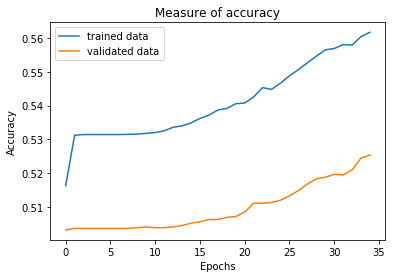

In [47]:
plt.plot(nn_history.history['acc'], label = 'trained data')
plt.plot(nn_history.history['val_acc'], label = 'validated data')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Measure of accuracy')
plt.show()

**Model is perfectly fit if not slightly overfit but we trained for 100 epochs so that is expected**

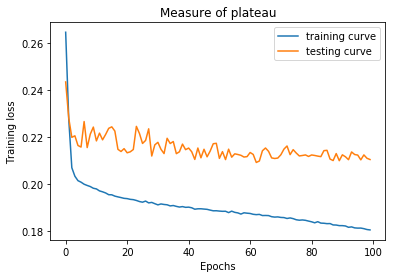

In [43]:
plt.plot(nn_history.history['loss'], label = 'training curve')
plt.plot(nn_history.history['val_loss'], label = 'testing curve')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.title('Measure of plateau')
plt.show()

**Measuring the training loss to recheck model**

**More Hyperparameter tuning: selu with logcosh amd sgd. epoch of 35. initializer zeros**

In [0]:
def mean_pred(X_test, Y_test):
    return K.mean(Y_test)

def build_model(inputs, output_size, neurons, activ_func="selu",
                dropout=0.10, loss="logcosh", optimizer="sgd"):
    
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(WINDOW,EMB_SIZE)))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size, kernel_initializer='random_uniform'))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', mean_pred])
    return model

In [46]:
nn_model = build_model(X_train, output_size=2, neurons = 32)
# model output is next price normalised to 10th previous closing price
# train model on data
# note: eth_history contains information on the training error per epoch
nn_history = nn_model.fit(X_train, Y_train,
                            epochs=35, batch_size=256, verbose=1,  validation_data=(X_test, Y_test),shuffle=True)

Train on 40973 samples, validate on 4553 samples
Epoch 1/35
40973/40973 [==============================] - 13s 309us/step - loss: 0.1720 - acc: 0.5163 - mean_pred: 0.1431 - val_loss: 0.1441 - val_acc: 0.5032 - val_mean_pred: 0.2543
Epoch 2/35
40973/40973 [==============================] - 12s 282us/step - loss: 0.1321 - acc: 0.5312 - mean_pred: 0.3270 - val_loss: 0.1262 - val_acc: 0.5036 - val_mean_pred: 0.3795
Epoch 3/35
40973/40973 [==============================] - 12s 284us/step - loss: 0.1225 - acc: 0.5314 - mean_pred: 0.4162 - val_loss: 0.1218 - val_acc: 0.5036 - val_mean_pred: 0.4406
Epoch 4/35
40973/40973 [==============================] - 12s 282us/step - loss: 0.1202 - acc: 0.5314 - mean_pred: 0.4593 - val_loss: 0.1207 - val_acc: 0.5036 - val_mean_pred: 0.4705
Epoch 5/35
40973/40973 [==============================] - 12s 281us/step - loss: 0.1195 - acc: 0.5314 - mean_pred: 0.4801 - val_loss: 0.1204 - val_acc: 0.5036 - val_mean_pred: 0.4851
Epoch 6/35
40973/40973 [============

In [48]:
nn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 32)                4864      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
_________________________________________________________________
activation_3 (Activation)    (None, 2)                 0         
Total params: 4,930
Trainable params: 4,930
Non-trainable params: 0
_________________________________________________________________


In [49]:
acc = nn_model.evaluate(X_test, Y_test, batch_size=16)
print('Test accuracy:', acc)

4553/4553 [==============================] - 7s 2ms/step
('Test accuracy:', [0.11868744594708344, 0.5253678893103014, 0.49994405417449655])


**Accuracy at 52.53%**

**Plotting training data loss and validation data loss**

**As seeb data is overfit and doesn't do great with selu and logcosh because logcosh could remove non-linearity of data**

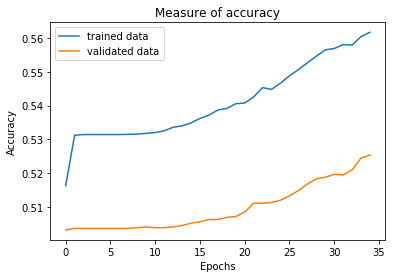

In [50]:
plt.plot(nn_history.history['acc'], label = 'trained data')
plt.plot(nn_history.history['val_acc'], label = 'validated data')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Measure of accuracy')
plt.show()

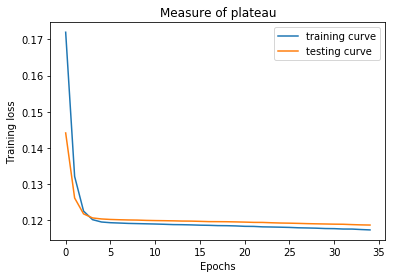

In [51]:
plt.plot(nn_history.history['loss'], label = 'training curve')
plt.plot(nn_history.history['val_loss'], label = 'testing curve')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.title('Measure of plateau')
plt.show()

**Not a lot of training and testing loss**

**More Hyperparamete tuning: Create a LSTM model with relu as activation function, mae as loss function, adam as optimizer and train for 50 epochs.**

In [0]:

def mean_pred(X_test, Y_test):
    return K.mean(Y_test)

def build_model(inputs, output_size, neurons, activ_func="relu",
                dropout=0.10, loss="mae", optimizer="adam"):
    
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(WINDOW,EMB_SIZE)))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', mean_pred])
    return model

In [54]:
nn_model = build_model(X_train, output_size=2, neurons = 32)
# model output is next price normalised to 10th previous closing price
# train model on data
# note: eth_history contains information on the training error per epoch
nn_history = nn_model.fit(X_train, Y_train,
                            epochs=50, batch_size=256, verbose=1,  validation_data=(X_test, Y_test),shuffle=True)

Train on 40973 samples, validate on 4553 samples
Epoch 1/50
40973/40973 [==============================] - 13s 314us/step - loss: 0.4701 - acc: 0.5279 - mean_pred: 0.2650 - val_loss: 0.4665 - val_acc: 0.5148 - val_mean_pred: 0.3484
Epoch 2/50
40973/40973 [==============================] - 12s 282us/step - loss: 0.4089 - acc: 0.6385 - mean_pred: 0.3944 - val_loss: 0.4039 - val_acc: 0.6501 - val_mean_pred: 0.4177
Epoch 3/50
40973/40973 [==============================] - 12s 283us/step - loss: 0.3759 - acc: 0.6888 - mean_pred: 0.4134 - val_loss: 0.3931 - val_acc: 0.6600 - val_mean_pred: 0.3717
Epoch 4/50
40973/40973 [==============================] - 12s 282us/step - loss: 0.3677 - acc: 0.6941 - mean_pred: 0.4166 - val_loss: 0.3891 - val_acc: 0.6574 - val_mean_pred: 0.4103
Epoch 5/50
40973/40973 [==============================] - 12s 283us/step - loss: 0.3632 - acc: 0.6964 - mean_pred: 0.4120 - val_loss: 0.3925 - val_acc: 0.6591 - val_mean_pred: 0.4556
Epoch 6/50
40973/40973 [============

In [55]:
nn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 32)                4864      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 66        
_________________________________________________________________
activation_5 (Activation)    (None, 2)                 0         
Total params: 4,930
Trainable params: 4,930
Non-trainable params: 0
_________________________________________________________________


In [56]:
acc = nn_model.evaluate(X_test, Y_test, batch_size=16)
print('Test accuracy:', acc)

4553/4553 [==============================] - 7s 2ms/step
('Test accuracy:', [0.3511478917535363, 0.6694487151525164, 0.46290524976478153])


**Test Accuracy at 66.94%**

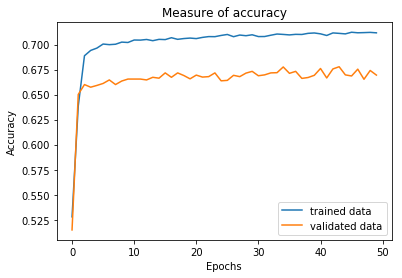

In [57]:
#Plotting training data loss and validation data loss
plt.plot(nn_history.history['acc'], label = 'trained data')
plt.plot(nn_history.history['val_acc'], label = 'validated data')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Measure of accuracy')
plt.show()

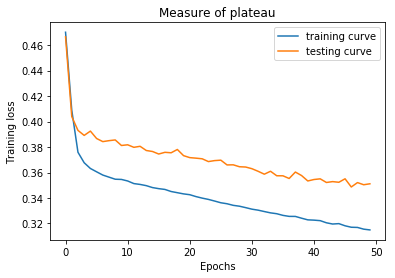

In [58]:
#plateau:
plt.plot(nn_history.history['loss'], label = 'training curve')
plt.plot(nn_history.history['val_loss'], label = 'testing curve')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.title('Measure of plateau')
plt.show()

**USE GRU NETWORK ARCHITECTURE**

**Created a GRU network in Keras and then run it for some time. Here I haven't performed much parameter tuning. Trained for 20 epochs on relu, mae and adam.** 


In [59]:
def mean_pred(X_test, Y_test):
    return K.mean(Y_test)

def build_model(inputs, output_size, neurons, activ_func="relu",
                dropout=0.10, loss="mae", optimizer="adam"):
    
    model = Sequential()

    model.add(GRU(neurons, input_shape=(WINDOW,EMB_SIZE)))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', mean_pred])
    return model

nn_model = build_model(X_train, output_size=2, neurons = 32)
# model output is next price normalised to 10th previous closing price
# train model on data
# note: eth_history contains information on the training error per epoch
nn_history = nn_model.fit(X_train, Y_train,
                            epochs=20, batch_size=256, verbose=1,  validation_data=(X_test, Y_test),shuffle=True)

Train on 40973 samples, validate on 4553 samples
Epoch 1/20
40973/40973 [==============================] - 11s 273us/step - loss: 0.4955 - acc: 0.4835 - mean_pred: 0.1472 - val_loss: 0.4840 - val_acc: 0.4968 - val_mean_pred: 0.1995
Epoch 2/20
40973/40973 [==============================] - 10s 238us/step - loss: 0.4567 - acc: 0.5254 - mean_pred: 0.2413 - val_loss: 0.4425 - val_acc: 0.5678 - val_mean_pred: 0.2791
Epoch 3/20
40973/40973 [==============================] - 10s 240us/step - loss: 0.3961 - acc: 0.6640 - mean_pred: 0.4123 - val_loss: 0.4014 - val_acc: 0.6503 - val_mean_pred: 0.4085
Epoch 4/20
40973/40973 [==============================] - 10s 240us/step - loss: 0.3748 - acc: 0.6900 - mean_pred: 0.4206 - val_loss: 0.3931 - val_acc: 0.6565 - val_mean_pred: 0.3948
Epoch 5/20
40973/40973 [==============================] - 10s 239us/step - loss: 0.3682 - acc: 0.6939 - mean_pred: 0.4198 - val_loss: 0.3895 - val_acc: 0.6618 - val_mean_pred: 0.3986
Epoch 6/20
40973/40973 [============

In [0]:
nn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                3648      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
_________________________________________________________________
activation_3 (Activation)    (None, 2)                 0         
Total params: 3,714
Trainable params: 3,714
Non-trainable params: 0
_________________________________________________________________


In [60]:
acc = nn_model.evaluate(X_test, Y_test, batch_size=16)
print('Test accuracy:', acc)

4553/4553 [==============================] - 6s 1ms/step
('Test accuracy:', [0.3759548671555053, 0.6681309027080611, 0.444116572992843])


Accuracy at 66.81%

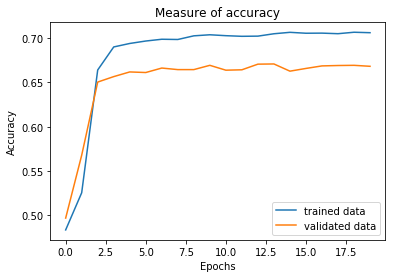

In [61]:
#Plotting training data loss and validation data loss
plt.plot(nn_history.history['acc'], label = 'trained data')
plt.plot(nn_history.history['val_acc'], label = 'validated data')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Measure of accuracy')
plt.show()

**A great model for both accuracy and loss. GRU does a good job like LSTM network.**

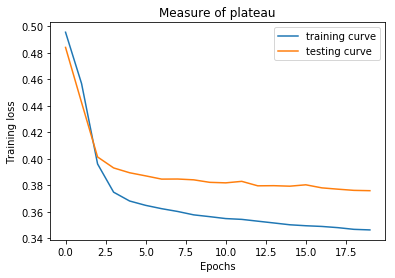

In [63]:
plt.plot(nn_history.history['loss'], label = 'training curve')
plt.plot(nn_history.history['val_loss'], label = 'testing curve')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.title('Measure of plateau')
plt.show()

#**CONCLUSIONS:**

**I found that LSTM and GRU can predict Closing prices of Amazon Data on an average of 65% of the time(best model at 75% worst at 58%) if you normalize the data, stack input data and perform hyperparameter tuning.** 
